# Species Distribution Modellin in Python

In [107]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import geowombat as gw # remote sensing and spatial operations
import geopandas as gpd

# import dask
# from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
import os
import glob

In [2]:
%matplotlib inline

In [3]:
import os
os.getcwd()

'/home/rvalavi/Documents/SDM_with_Python'

### *Listing raster layers*

In [4]:
rlist = glob.glob("Rasters/*.tif")
rlist

['Rasters/tempann.tif',
 'Rasters/vegsys.tif',
 'Rasters/solrad.tif',
 'Rasters/topo.tif',
 'Rasters/raindq.tif',
 'Rasters/cti.tif',
 'Rasters/mi.tif',
 'Rasters/soildepth.tif',
 'Rasters/rugged.tif',
 'Rasters/rainann.tif',
 'Rasters/soilfert.tif',
 'Rasters/tempmin.tif',
 'Rasters/disturb.tif']

In [77]:
names = [i[8:-4] for i in rlist]
names[0:3]

['tempann', 'vegsys', 'solrad']

CPU times: user 231 ms, sys: 28.7 ms, total: 260 ms
Wall time: 248 ms


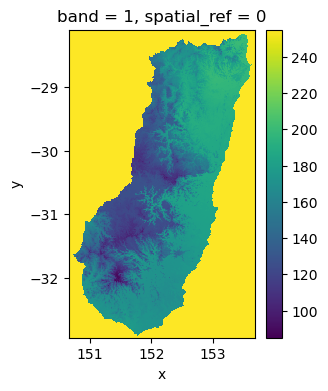

In [6]:
%%time
plt.figure(figsize=(3,4))
tempann = rxr.open_rasterio('Rasters/tempann.tif', chunks={'x':1689, 'y':1797})
tempann[0::10, 0::10].plot()

### *Reading occurrence points*

In [7]:
# import point data
points = pd.read_csv("Records/train_po/NSWtrain_po.csv")
occ = points[points["spid"] == "nsw14"]
occ = occ[['occ', 'x', 'y']]
occ.shape

(315, 3)

In [8]:
geo_occ = gpd.GeoDataFrame(occ, geometry=gpd.points_from_xy(occ.x, occ.y))
geo_occ.head()

,occ,x,y,geometry
1149,1,153.4879,-28.1642,POINT (153.48790 -28.16420)
1150,1,153.4838,-28.1651,POINT (153.48380 -28.16510)
1151,1,153.4930,-28.1696,POINT (153.49300 -28.16960)
1152,1,152.5070,-28.2522,POINT (152.50700 -28.25220)
1153,1,152.4990,-28.2567,POINT (152.49900 -28.25670)


### *Generating random background samples*

In [52]:
from shapely.geometry import Point

def random_points_in_polygon(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds.values[0]
    x = np.random.uniform(minx, maxx, number)
    y = np.random.uniform(miny, maxy, number)
    
    df = pd.DataFrame()
    df['geometry'] = list(zip(x,y))
    df['geometry'] = df['geometry'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='geometry')
    
    Sjoin = gpd.tools.sjoin(gdf_points, polygon, predicate="within", how='left')

    # Keep points in "myPoly"
    pnts_in_poly = gdf_points[Sjoin.index_right==0]

    return pnts_in_poly

In [53]:
# read the border file
border = gpd.read_file("nsw.gpkg")

In [54]:
bg = random_points_in_polygon(border, 1_000)
bg.shape

(506, 1)

In [55]:
bg['occ'] = 0
bg.head()

,geometry,occ
1,POINT (151.83963 -32.51066),0
3,POINT (152.56233 -29.00316),0
6,POINT (151.84881 -32.39395),0
9,POINT (152.47296 -31.44974),0
12,POINT (152.19007 -32.27383),0


<AxesSubplot:>

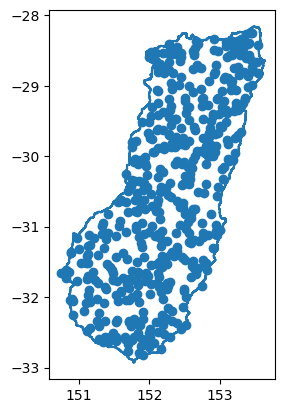

In [56]:
fig, ax = plt.subplots()

border.boundary.plot(ax=ax)
bg.plot(ax=ax)

### *Combine occurrence and background sample*

In [81]:
samples = pd.concat([geo_occ[['occ', 'geometry']], bg])
samples.head()

,occ,geometry
1149,1,POINT (153.48790 -28.16420)
1150,1,POINT (153.48380 -28.16510)
1151,1,POINT (153.49300 -28.16960)
1152,1,POINT (152.50700 -28.25220)
1153,1,POINT (152.49900 -28.25670)


In [67]:
samples.groupby('occ').count()

,geometry
occ,
0,506
1,315


In [82]:
# save to file
samples.to_file('occurrence.gpkg', driver='GPKG', layer='name')

### *Extrating raster values for model training*

In [84]:
%%time
with gw.open(rlist, chunks=(1689, 1797)) as src:
    train_gdf = src.gw.extract('occurrence.gpkg', time_names=names, band_names=None)

CPU times: user 1.12 s, sys: 120 ms, total: 1.24 s
Wall time: 929 ms


In [86]:
train_gdf

,occ,geometry,id,tempann_1,vegsys_1,solrad_1,topo_1,raindq_1,cti_1,mi_1,soildepth_1,rugged_1,rainann_1,soilfert_1,tempmin_1,disturb_1
0,1,POINT (153.48790 -28.16420),0,200,5,89,-1,216,1339,88,1139,11,1590,2,85,3
1,1,POINT (153.48380 -28.16510),1,199,5,89,-3,216,1439,88,1149,15,1592,2,84,3
2,1,POINT (153.49300 -28.16960),2,200,5,89,-1,222,1629,89,1159,1,1594,2,86,3
3,1,POINT (152.50700 -28.25220),3,159,2,86,-3,222,1259,92,1080,28,1580,2,45,2
4,1,POINT (152.49900 -28.25670),4,158,2,88,-3,222,1279,91,1110,51,1568,2,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,0,POINT (152.13630 -30.79730),816,163,1,89,36,126,1079,81,910,116,880,2,31,1
817,0,POINT (152.29045 -28.56116),817,176,7,97,-16,126,1509,56,990,24,866,2,36,3
818,0,POINT (152.30402 -29.87501),818,172,4,95,16,132,1119,57,899,36,914,2,41,3
819,0,POINT (152.11697 -30.29578),819,116,9,89,14,144,1179,79,1019,23,896,2,0,4


<AxesSubplot:>

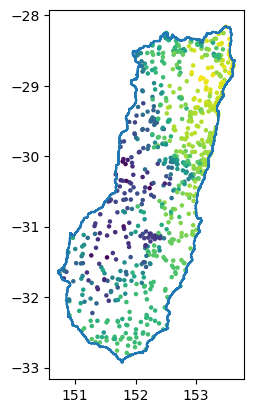

In [102]:
base = border.boundary.plot()
train_gdf.plot(ax=base, column='tempann_1', markersize=5)

In [103]:
train_df = train_gdf[['tempann_1', 'solrad_1', 'topo_1', 'raindq_1', 'cti_1', 'mi_1', 'soildepth_1', 'rugged_1', 'rainann_1', 'soilfert_1', 'tempmin_1']]
col_names = {i:i[0:-2] for i in train_df.columns}
X = train_df.rename(columns=col_names)
X.head()

,tempann,solrad,topo,raindq,cti,mi,soildepth,rugged,rainann,soilfert,tempmin
0,200,89,-1,216,1339,88,1139,11,1590,2,85
1,199,89,-3,216,1439,88,1149,15,1592,2,84
2,200,89,-1,222,1629,89,1159,1,1594,2,86
3,159,86,-3,222,1259,92,1080,28,1580,2,45
4,158,88,-3,222,1279,91,1110,51,1568,2,44


In [104]:
y = train_gdf['occ']
y.unique()

array([1, 0])

### *Model fitting*

In [196]:
from sklearn.model_selection import GridSearchCV, KFold
# from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [197]:
rf_model = RandomForestClassifier()

In [198]:
rf_model.fit(X, y)

RandomForestClassifier()

In [199]:
# predict on the training samples
train_predicted = rf_model.predict_proba(X)
train_predicted.shape

(821, 2)

In [200]:
train_predicted

array([[0.09, 0.91],
       [0.05, 0.95],
       [0.08, 0.92],
       ...,
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.98, 0.02]])

In [201]:
train_gdf['prediction'] = train_predicted[:,1]

<AxesSubplot:>

<Figure size 200x200 with 0 Axes>

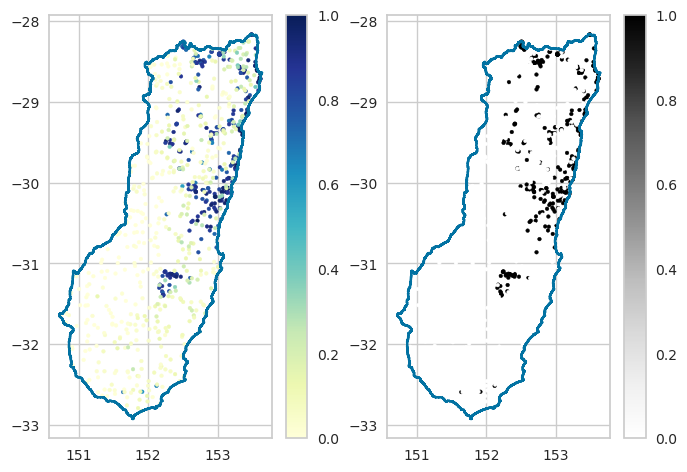

In [202]:
plt.figure(figsize=(2,2))
fig, (ax1, ax2) = plt.subplots(1,2)

base = border.boundary.plot(ax=ax1)
train_gdf.plot(ax=base, column='prediction', markersize=7, cmap='YlGnBu', legend=True)

base = border.boundary.plot(ax=ax2)
train_gdf.plot(ax=base, column='occ', markersize=7, legend=True)

### *Fitting mdoel on xarray*

In [203]:
from sklearn_xarray import wrap

In [209]:
rf_model_xr = wrap(RandomForestClassifier())

In [210]:
rf_model_xr.fit(X, y)

EstimatorWrapper(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                 criterion='gini', estimator=RandomForestClassifier(),
                 max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                 max_samples=None, min_impurity_decrease=0.0,
                 min_samples_leaf=1, min_samples_split=2,
                 min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                 oob_score=False, random_state=None, verbose=0,
                 warm_start=False)

In [211]:
x_rasters = ['Rasters/' + i + '.tif' for i in X.columns]
x_rasters

['Rasters/tempann.tif',
 'Rasters/solrad.tif',
 'Rasters/topo.tif',
 'Rasters/raindq.tif',
 'Rasters/cti.tif',
 'Rasters/mi.tif',
 'Rasters/soildepth.tif',
 'Rasters/rugged.tif',
 'Rasters/rainann.tif',
 'Rasters/soilfert.tif',
 'Rasters/tempmin.tif']

In [212]:
with gw.open(x_rasters, chunks=(1800, 1800)) as src:
    Xr = src

In [213]:
Xr

<xarray.DataArray (time: 11, band: 1, y: 5390, x: 3378)>
dask.array<concatenate, shape=(11, 1, 5390, 3378), dtype=int32, chunksize=(1, 1, 1800, 1800), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * x        (x) float64 150.6 150.7 150.7 150.7 ... 153.7 153.7 153.7 153.7
  * y        (y) float64 -28.1 -28.1 -28.1 -28.11 ... -32.95 -32.95 -32.95
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 11
Attributes:
    transform:           (0.0008993220458851423, 0.0, 150.648947319, 0.0, -0....
    crs:                 4326
    res:                 (0.0008993220458851423, 0.0008993220460111314)
    is_tiled:            0
    nodatavals:          (255.0,)
    _FillValue:          255.0
    scales:              (1.0,)
    offsets:             (0.0,)
    AREA_OR_POINT:       Area
    filename:            ['tempann.tif', 'solrad.tif', 'topo.tif', 'raindq.ti...
    resampling:          nearest
    _data_are_separate:  1
    _data_are_stacked:   1

In [ ]:
#### rf_model_xr.predict_proba(Xr)

# Modelling test with GeoWombat

In [17]:
from geowombat.data import l8_224078_20200518, l8_224078_20200518_polygons

In [18]:
from geowombat.ml import fit, predict, fit_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

In [19]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn_xarray.model_selection import CrossValidatorWrapper

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

In [29]:
model_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier()) # SelectKBest(k=3), 

In [30]:
cv = CrossValidatorWrapper(KFold(n_splits=5))

In [31]:
params = {'n_neighbors': [4, 6, 8,]}

In [32]:
gridsearch = GridSearchCV(model_pipeline, cv=cv, scoring='balanced_accuracy', param_grid=params)

In [33]:
gridsearch

GridSearchCV(cv=<sklearn_xarray.model_selection.CrossValidatorWrapper object at 0x7f12c553e2c0>,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'n_neighbors': [4, 6, 8]},
             scoring='balanced_accuracy')

In [ ]:
%%time
with gw.open(selected_vars, chunks=128) as src:
    y = fit_predict(src, model_pipeline, labels, col='occ')
    print(y)